In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# labels_df = pd.read_csv('/content/drive/My Drive/CS577/Brains/labels.csv')
# labels = np.array(labels_df[' hemorrhage'].tolist())

# files = sorted(glob.glob('/content/drive/My Drive/CS577/Brains/head_ct/*.png'))
# images = np.array([cv2.imread(path) for path in files])
# images = np.array([cv2.resize(image, (64, 64)) for image in images])

In [9]:
import keras

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import math

# Image augmentation

In [40]:
train_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
).flow_from_directory('/content/data/', class_mode='binary', batch_size=128, target_size=(64,64),)

validation_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=90,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0).flow_from_directory('/content/val/', class_mode='binary', batch_size=128, target_size=(64,64),)

Found 1432 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


# Building the model

In [0]:
def check_accuracy(model, setX, actual, print_images=True):
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)])
    if print_images:
        rows = math.ceil(len(predicted)/10.)
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)):
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
        
    confusion = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = confusion.ravel()
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%")
    return (tn, fp, fn, tp)

In [0]:
def simple_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [0]:
model = simple_conv_model((64, 64, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

# Training model

In [49]:
model_history = model.fit_generator(train_image_data,
    steps_per_epoch=128,
    validation_data=validation_image_data,
    validation_steps=100,
    callbacks=[ModelCheckpoint("weights.h5", monitor='val_acc', save_best_only=True, mode='max')],
    epochs=16)

Epoch 1/16
128/128 [==============================] - 62s 483ms/step - loss: 0.6304 - accuracy: 0.6473 - val_loss: 0.5187 - val_accuracy: 0.7935
Epoch 2/16
  1/128 [..............................] - ETA: 1s - loss: 0.5461 - accuracy: 0.7578

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


128/128 [==============================] - 62s 482ms/step - loss: 0.5285 - accuracy: 0.7420 - val_loss: 0.3882 - val_accuracy: 0.8513
Epoch 3/16
128/128 [==============================] - 61s 477ms/step - loss: 0.4620 - accuracy: 0.7929 - val_loss: 0.4124 - val_accuracy: 0.8197
Epoch 4/16
128/128 [==============================] - 59s 460ms/step - loss: 0.4126 - accuracy: 0.8259 - val_loss: 0.2784 - val_accuracy: 0.8951
Epoch 5/16
128/128 [==============================] - 61s 478ms/step - loss: 0.3804 - accuracy: 0.8435 - val_loss: 0.3379 - val_accuracy: 0.8650
Epoch 6/16
128/128 [==============================] - 61s 474ms/step - loss: 0.3490 - accuracy: 0.8626 - val_loss: 0.1824 - val_accuracy: 0.9176
Epoch 7/16
128/128 [==============================] - 59s 464ms/step - loss: 0.3148 - accuracy: 0.8791 - val_loss: 0.2295 - val_accuracy: 0.9134
Epoch 8/16
128/128 [==============================] - 61s 479ms/step - loss: 0.3044 - accuracy: 0.8848 - val_loss: 0.2596 - val_accuracy: 0.9

In [0]:
def viz_model_performance(acc, val_acc, loss, val_loss):
    fig,a = plt.subplots(1,2, figsize=(12,5))

    a[0].plot(acc)
    a[0].plot(val_acc)
    a[0].set_title('Model accuracy')
    a[0].set_ylabel('Accuracy')
    a[0].set_xlabel('Epoch')
    a[0].legend(['Train', 'Validation'], loc='upper left')

    a[1].plot(loss)
    a[1].plot(val_loss)
    a[1].set_title('Model loss')
    a[1].set_ylabel('Loss')
    a[1].set_xlabel('Epoch')
    a[1].legend(['Train', 'Validation'], loc='upper right')
    plt.show()

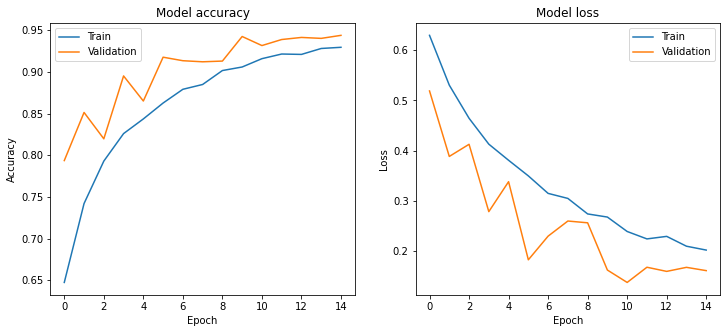

In [52]:
viz_model_performance(model_history.history['accuracy'][:-1],
                      model_history.history['val_accuracy'][:-1],
                      model_history.history['loss'][:-1],
                      model_history.history['val_loss'][:-1])

In [0]:
model.save("final_weights_classifier.h5")

The overall generalization of model seems good, overfitting isn't too big. But since this is a medical problem, we have to consider one additional thing.